# Task description
## Background
One application of Machine Learning in an eCommerce setting is to find the best products for a specific search query. Even the best algorithms, however, are not guaranteed to be optimal, in the sense that occasionaly some products chosen by the algorithm for a query may in fact be irrelevant. This may not be good for the customer experience, since the customer may wonder why irrelevant products are shown in the result page. Hence it is important to identify these products and not show them to the customers.
## Goal
The goal of this exercise is to create an algorithm that identifies these irrelevant results based on product attributes. We provide you with a small dataset containing the products returned by a black-box ML algorithm for a set of queries, together with a label describing if a product is irrelevant to the respective query. The goal of the assignment is to write an algorithm that detects these irrelevant products based on the product attributes present in the data. This algorithm could then be used to remove irrelevant products from other queries, hence improving the search experience of our customers.
## Deliverables
The result of the exercise should be this notebook containing the following sections:
* Load the data
* Short data analysis
  * Description of the data (number of queries, number of products per query, number of available attributes,...)
  * Plot of a histogram showing the number of queries with varying percentage of irrelevant products in the result set
* Algorithm implementation
* Algorithm evaluation
  * Dictionary named "query_results" containing accuracy, precision, recall and F1-score for each query as {'query1':{'accuracy':value,'precision':value,...},'query2':{...}}
  * Dictionary named "results" containing mean accuracy, precision, recall and F1-score over all queries as {'accuracy':value, 'precision':value,...}

# Load Data

In [3]:
import seaborn as sns
from statistics import *
from statistics import stdev

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv ("../input/nllllpppp/data.csv")
df[0:120]

,query,price_cluster,commodity_group,product_group,silhouette,brand,color,upper_material,pattern,label
0,t-shirt dolce gabbana,low,4-2-B-01-1,shoe,backless_slipper,adidas Performance,schwarz,Kunststoff,print,1
1,t-shirt dolce gabbana,low,1-2-G-3,shoe,backless_slipper,Guess,schwarz,Kunststoff,unifarben,1
2,t-shirt dolce gabbana,low,1-2-G-4,shoe,backless_slipper,Tommy Hilfiger,rot,Leder und Textil,gestreift,1
3,t-shirt dolce gabbana,high,1-2-G-3,shoe,backless_slipper,MOSCHINO,schwarz,hochwertiges Lederimitat,unifarben,1
4,t-shirt dolce gabbana,low,1-2-C-1,shoe,low_shoe,Pier One,gelb,Textil,unifarben,1
...,...,...,...,...,...,...,...,...,...,...
115,selected femme boots,medium,1-1-N-Z,shoe,ankle_boots,Pavement,schwarz,Nubuk,unifarben,0
116,selected femme boots,high,1-1-X-01,shoe,ankle_boots,Pretty Ballerinas,schwarz,Veloursleder,unifarben,0
117,selected femme boots,low,5-1-H-04-10,accessoires,bag,Pieces,beige,undefined,unifarben,1
118,selected femme boots,medium,1-1-X-01,shoe,sneaker,Högl,braun,Kalbsleder,undefined,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


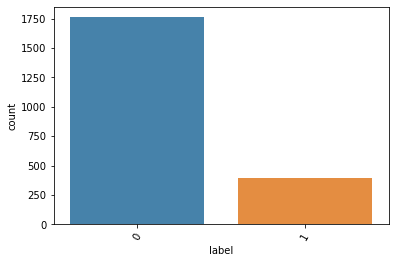

In [49]:
sns.countplot(df['label'],label="Count",alpha=0.9)
plt.xticks(rotation=60)

plt.show()

In [50]:
print('The shape of our features is:', df.shape)
df=df.replace(np.nan,0)

The shape of our features is: (2160, 10)


In [51]:
# check missing values in variables

df.isnull().sum()

query              0
price_cluster      0
commodity_group    0
product_group      0
silhouette         0
brand              0
color              0
upper_material     0
pattern            0
label              0
dtype: int64

In [52]:
print(df['query'].unique())
print(df['price_cluster'].unique())
#print(df['commodity_group'].unique())
print(df['product_group'].unique())
print(df['silhouette'].unique())
print(df['brand'].unique())
print(df['upper_material'].unique())
print(df['pattern'].unique())



['t-shirt dolce gabbana' 'selected femme boots' 'hairband sport'
 'halskragenpullover' 'stiefeletten pepe jeans' 'barney jacke'
 'chelsea wide' 'california west coast pullover'
 'carhartt wip windbreaker' 'save the duck mäntel damen'
 'collegejacken vintage' 'converse schuhe herz'
 'naketano damen kapuzenjacken' 'sonnenbrille chanel'
 'british knights master lo' 'aigle stiefel' 'asics gel venture 8'
 'tshirt kleid kurz' 'jumpsuits kariert' 'damenchino' 'joggpants kinder'
 'baggy trackpant' 'wanderschuhe lowa kinder' 'regenjacke joules'
 'nike pullover vintage' 'lacoste taschen sale' 'jogging cargo']
['low' 'high' 'entry' 'medium' 'undefined']
['shoe' 'clothing' 'accessoires' 'equipment' 'beauty' 'other' 'underwear'
 'beach_wear' 'nightwear']
['backless_slipper' 'low_shoe' 'sandals' 't_shirt_top' 'trouser' 'belt'
 'ankle_boots' 'coat' 'boots' 'bag' 'sneaker' 'fitness' 'jewellery'
 'beauty_equipment' 'other_equipment' 'gloves' 'headgear'
 'other_accessoires' 'scarf' 'pullover' 'cardigan'

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


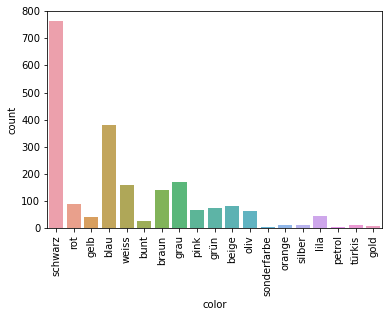

In [53]:
sns.countplot(df['color'],label="Count",alpha=0.9)
plt.xticks(rotation=90)

plt.show()

<Figure size 1080x576 with 0 Axes>

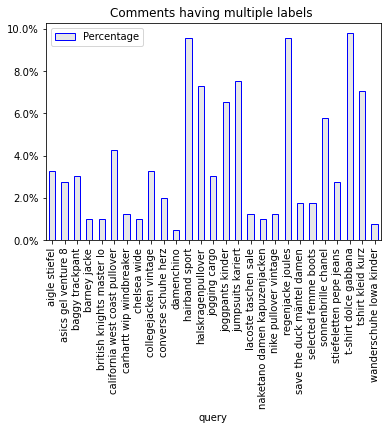

In [20]:
import matplotlib.ticker as mtick
plt.figure(figsize=(15,8))

h1=df.groupby(['query'],as_index=False).agg({'label':pd.Series.sum})
P = df.groupby('query')['label'].sum().reset_index()
print(P)
P['Percentage'] = 100 * P['label']  / P['label'].sum()
ax = P.plot.bar(x='query',y='Percentage',color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
plt.title("Comments having multiple labels ")

ax.yaxis.set_major_formatter(mtick.PercentFormatter())



In [17]:
P

NameError: name 'P' is not defined

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

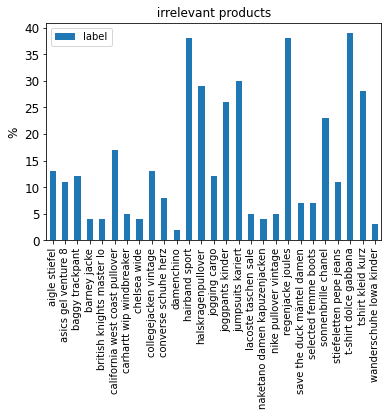

In [55]:
%matplotlib inline
h1.plot(x='query',kind="bar")
plt.xticks(rotation=30)
plt.title(" irrelevant products ")
plt.ylabel('%', fontsize=12)
plt.xlabel('', fontsize=12)

plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=12)

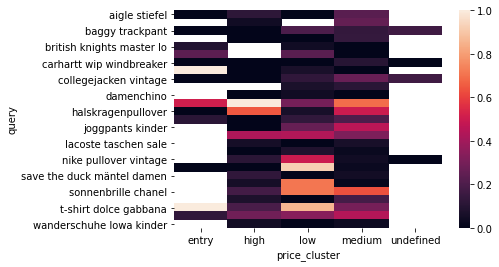

In [56]:
df2=df.copy()
df_heatmap = df2.pivot_table(values='label',index='query',columns='price_cluster',aggfunc=np.mean)
sns.heatmap(df_heatmap)
plt.show()
#annot=True,fmt='g'

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df1=df.copy() 

values = df1["query"].unique().tolist()


df1["query"] = label_encoder.fit_transform(df1["query"]).astype('float64')
df1["price_cluster"] = label_encoder.fit_transform(df1["price_cluster"]).astype('float64')
df1["product_group"] = label_encoder.fit_transform(df1["product_group"].apply(str)).astype('float64')
df1["silhouette"] = label_encoder.fit_transform(df1["silhouette"].apply(str)).astype('float64')
df1["brand"] = label_encoder.fit_transform(df1["brand"].apply(str)).astype('float64')
df1["upper_material"] = label_encoder.fit_transform(df1["upper_material"].apply(str)).astype('float64')

df1["pattern"] = label_encoder.fit_transform(df1["pattern"].apply(str)).astype('float64')
df1["color"] = label_encoder.fit_transform(df1["color"].apply(str)).astype('float64')


keys= df1["query"].unique().tolist()

encoded_dic={}

for key,value in zip(keys,values):
    encoded_dic[key] = value


In [91]:
encoded_dic

{24.0: 't-shirt dolce gabbana',
 21.0: 'selected femme boots',
 11.0: 'hairband sport',
 12.0: 'halskragenpullover',
 23.0: 'stiefeletten pepe jeans',
 3.0: 'barney jacke',
 7.0: 'chelsea wide',
 5.0: 'california west coast pullover',
 6.0: 'carhartt wip windbreaker',
 20.0: 'save the duck mäntel damen',
 8.0: 'collegejacken vintage',
 9.0: 'converse schuhe herz',
 17.0: 'naketano damen kapuzenjacken',
 22.0: 'sonnenbrille chanel',
 4.0: 'british knights master lo',
 0.0: 'aigle stiefel',
 1.0: 'asics gel venture 8',
 25.0: 'tshirt kleid kurz',
 15.0: 'jumpsuits kariert',
 10.0: 'damenchino',
 14.0: 'joggpants kinder',
 2.0: 'baggy trackpant',
 26.0: 'wanderschuhe lowa kinder',
 19.0: 'regenjacke joules',
 18.0: 'nike pullover vintage',
 16.0: 'lacoste taschen sale',
 13.0: 'jogging cargo'}

In [ ]:
df1[800:802]

In [59]:
df1.drop(["commodity_group"], inplace=True, axis=1)
df1

,query,price_cluster,product_group,silhouette,brand,color,upper_material,pattern,label
0,24.0,2.0,7.0,1.0,490.0,14.0,4.0,13.0,1
1,24.0,2.0,7.0,1.0,171.0,14.0,4.0,15.0,1
2,24.0,2.0,7.0,1.0,437.0,13.0,8.0,10.0,1
3,24.0,1.0,7.0,1.0,260.0,14.0,22.0,15.0,1
4,24.0,2.0,7.0,20.0,348.0,4.0,18.0,15.0,1
...,...,...,...,...,...,...,...,...,...
2155,13.0,3.0,3.0,38.0,8.0,9.0,23.0,15.0,0
2156,13.0,0.0,3.0,38.0,332.0,2.0,23.0,14.0,0
2157,13.0,2.0,3.0,38.0,456.0,14.0,23.0,15.0,0
2158,13.0,0.0,3.0,31.0,421.0,6.0,23.0,14.0,0


In [60]:
print(df['query'].unique())



['t-shirt dolce gabbana' 'selected femme boots' 'hairband sport'
 'halskragenpullover' 'stiefeletten pepe jeans' 'barney jacke'
 'chelsea wide' 'california west coast pullover'
 'carhartt wip windbreaker' 'save the duck mäntel damen'
 'collegejacken vintage' 'converse schuhe herz'
 'naketano damen kapuzenjacken' 'sonnenbrille chanel'
 'british knights master lo' 'aigle stiefel' 'asics gel venture 8'
 'tshirt kleid kurz' 'jumpsuits kariert' 'damenchino' 'joggpants kinder'
 'baggy trackpant' 'wanderschuhe lowa kinder' 'regenjacke joules'
 'nike pullover vintage' 'lacoste taschen sale' 'jogging cargo']


In [61]:
encoded_dic={} #key : encoded # value: decoded(query)

df['query'].unique()




array(['t-shirt dolce gabbana', 'selected femme boots', 'hairband sport',
       'halskragenpullover', 'stiefeletten pepe jeans', 'barney jacke',
       'chelsea wide', 'california west coast pullover',
       'carhartt wip windbreaker', 'save the duck mäntel damen',
       'collegejacken vintage', 'converse schuhe herz',
       'naketano damen kapuzenjacken', 'sonnenbrille chanel',
       'british knights master lo', 'aigle stiefel',
       'asics gel venture 8', 'tshirt kleid kurz', 'jumpsuits kariert',
       'damenchino', 'joggpants kinder', 'baggy trackpant',
       'wanderschuhe lowa kinder', 'regenjacke joules',
       'nike pullover vintage', 'lacoste taschen sale', 'jogging cargo'],
      dtype=object)

In [62]:
print(df['pattern'].unique())


['print' 'unifarben' 'gestreift' 'undefined' 'animal print' 'bunt'
 'geblümt' 'meliert' 'gepunktet' 'kariert' 'Camouflage' 'Farbverlauf'
 'Fotoprint' 'Paisley' 'Fischgrat' 'Nadelstreifen']


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


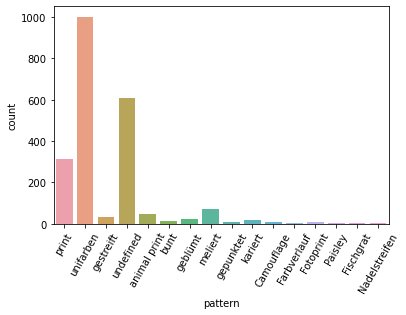

In [63]:
sns.countplot(df['pattern'],label="Count",alpha=0.9)
plt.xticks(rotation=60)

plt.show()

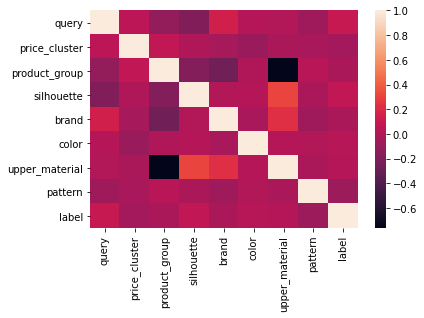

In [64]:
df2=df1.copy()
df2 = df2[['query','price_cluster','product_group','silhouette','brand','color','upper_material','pattern','label']]
corr = df2.corr(method='pearson')
sns.heatmap(corr)
plt.show()


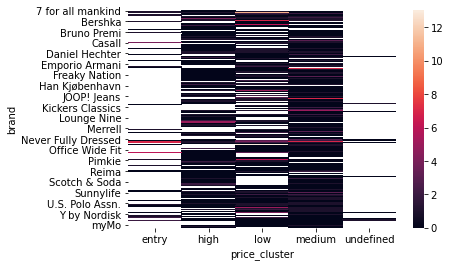

In [65]:
df2=df.copy()
df_heatmap = df2.pivot_table(values='label',index='brand',columns='price_cluster',aggfunc=pd.Series.sum)
sns.heatmap(df_heatmap)
plt.show()
#annot=True,fmt='g'

In [66]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #I
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier


feature_cols = ['query','price_cluster','product_group','silhouette','brand','color','upper_material','pattern']

#years_since_graduation
#how deal with continues feature in decision tree.

XX = df1[feature_cols]
y = df1['label']
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=100) # 70% training and 30% test


#Building Decision Tree Model

clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

results={"Accuracy":metrics.accuracy_score(y_test, y_pred), "precision":metrics.precision_score(y_test, y_pred),
        "recall":metrics.recall_score(y_test, y_pred), "f1-score":metrics.f1_score(y_test, y_pred) }


X_test = X_test.groupby('query')   

X_tests={x:X_test.get_group(x) for x in X_test.groups}
#print (X_tests)


query_results = []

for q in X_tests.keys():
    y_pred = clf.predict(X_tests[q])
    #X_tests[q].index  
    gt= y_test[X_tests[q].index]
    
    query_results.append({encoded_dic[q]:{"Accuracy":round(metrics.accuracy_score(gt, y_pred),2), "precision":round(metrics.precision_score(gt, y_pred),2),
        "recall":round(metrics.recall_score(gt, y_pred),2), "f1-score":round(metrics.f1_score(gt, y_pred),2)}})

print(query_results)      

[{'aigle stiefel': {'Accuracy': 0.89, 'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75}}, {'asics gel venture 8': {'Accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}}, {'baggy trackpant': {'Accuracy': 0.84, 'precision': 0.5, 'recall': 1.0, 'f1-score': 0.67}}, {'barney jacke': {'Accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}}, {'british knights master lo': {'Accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}}, {'california west coast pullover': {'Accuracy': 0.87, 'precision': 1.0, 'recall': 0.67, 'f1-score': 0.8}}, {'carhartt wip windbreaker': {'Accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}}, {'chelsea wide': {'Accuracy': 0.92, 'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}}, {'collegejacken vintage': {'Accuracy': 0.9, 'precision': 0.6, 'recall': 1.0, 'f1-score': 0.75}}, {'converse schuhe herz': {'Accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0}}, {'damenchino': {'Accuracy': 1.0, 'precision': 0.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.

In [97]:
print(y_test)

801     0
1059    0
1237    0
270     1
1720    0
       ..
625     0
595     1
887     0
1623    1
2080    0
Name: label, Length: 432, dtype: int64


In [87]:
X_tests

{'aigle stiefel':               query price_cluster commodity_group product_group   silhouette  \
 1200  aigle stiefel        medium        1-2-K-02          shoe  ankle_boots   
 1201  aigle stiefel        medium      4-2-J-01-1     underwear     stocking   
 1202  aigle stiefel        medium        1-2-K-02          shoe  ankle_boots   
 1203  aigle stiefel        medium      4-4-A-01-2          shoe        boots   
 1204  aigle stiefel        medium      8-2-F-01-5     underwear     stocking   
 ...             ...           ...             ...           ...          ...   
 1275  aigle stiefel          high      4-2-A-01-1          shoe     low_shoe   
 1276  aigle stiefel        medium        1-2-K-01          shoe  ankle_boots   
 1277  aigle stiefel           low         1-5-L-3          shoe        boots   
 1278  aigle stiefel        medium      4-4-C-01-2          shoe        boots   
 1279  aigle stiefel        medium        1-2-K-02          shoe  ankle_boots   
 
         

In [ ]:
X_train

In [ ]:
X_test

In [73]:
Results = metrics.classification_report(y_test, y_pred)
Results

'              precision    recall  f1-score   support\n\n           0       0.95      0.94      0.95       338\n           1       0.80      0.81      0.80        94\n\n    accuracy                           0.91       432\n   macro avg       0.87      0.88      0.87       432\nweighted avg       0.91      0.91      0.91       432\n'

In [ ]:
Results = {}


In [ ]:
'''df5 = pd.DataFrame(y_pred,columns =["class"])
X_test2=X_test.copy()
X_test2=X_test2.reset_index()
result = pd.merge(X_test2, df5, left_index=True, right_index=True)
result.head()'''

In [ ]:
#prediction_lg = classifier_lg.predict(new_X)
y_pred = clf.predict(X_test)
#prediction_df = pd.DataFrame(data={'query':X_test["query"], 'new_predictions': y_pred,'truth':y_test})
prediction_df = pd.DataFrame(data={'query':X_test["query"], 'new_predictions': y_pred,'truth':y_test})

prediction_df


In [ ]:
for q in prediction_df["query"]:
    print(encoded_dic[q])


#prediction_df["decoded_qouery"] = 

In [ ]:
x = [ 8,22,0,12,2,15,19,4,11,17,10,26,18,3,16,9,24,14,1,6,20,13,21,5,23,7,25]


In [ ]:
label_encoder.inverse_transform(X_test["query"].to_numpy())

In [ ]:
print(prediction_df['query'].unique())
print(df1['query'].unique())


In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances


In [ ]:
%matplotlib inline

importances.plot(x='feature', kind="bar")
plt.xticks(rotation=30)
plt.title(" Feature Importance")
plt.ylabel('message click', fontsize=12)
plt.xlabel('', fontsize=12)

plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=12)

In [ ]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 20))# List to store the average RMSE for each value of max_depth:
accuracy = []
for depth in max_depth_range:
  clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)
  accuracy.append(score)

#accuracy

plt.plot(max_depth_range, accuracy,color='g')
plt.xlabel('max_depth_range')
plt.ylabel('accuracy')
plt.title('Tuning the Depth of a Tree')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dic = {"criterion": ['gini','entropy'],
             "max_depth":range(1,20),
             "min_samples_split":range(1,20),
             "min_samples_leaf":range(1,10)}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix#for visualizing tree cm = confusion_matrix(y_train, y_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))

sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues',fmt='g')

plt.ylabel('Predicted label')

plt.xlabel('Actual label')

In [ ]:
from sklearn import tree
text_representation = tree.export_text(clf)
print(text_representation)

In [ ]:
# import Random Forest classifier
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
feature_cols = ['query','price_cluster','product_group','silhouette','brand','color','upper_material','pattern']

#years_since_graduation
#how deal with continues feature in decision tree.

X= df1[feature_cols]
y = df1['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

rfc = RandomForestClassifier(n_estimators=40,random_state=0)
# fit the model
rfc.fit(X_train, y_train)
# Predict the Test set results
y_pred = rfc.predict(X_test)
# Check accuracy score 
from sklearn.metrics import accuracy_score
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
for i in range(10):
	print(X[i], y_pred[i])

In [ ]:
#feature_cols = ['query','price_cluster','product_group','silhouette','brand','color','upper_material','pattern']

#24.0	2.0	7.0	1.0	171.0	14.0	4.0	15.0	1

rfc.fit(X, y)
row = [[24,2,7,1,171,14,4,15]]
yhat = rfc.predict(row)
print('Predicted Class: %d' % yhat[0])

In [ ]:
df.groupby('product_group')['label'].count()

In [ ]:
df.groupby('product_group')['label'].sum()

# Data analysis

In [ ]:
dd=df.groupby(['query',"product_group"],as_index=False).agg({'label':pd.Series.count})
dd

In [ ]:
#Plot of a histogram showing the number of queries with varying percentage of irrelevant products in the result set

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

In [ ]:
#Dictionary named "query_results" containing accuracy, precision, recall and F1-score for each query as {'query1':{'accuracy':value,'precision':value,...},'query2':{...}}
#Dictionary named "results" containing mean accuracy, precision, recall and F1-score over all queries as {'accuracy':value, 'precision':value,...}

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
report

# Algorithm

# Evaluation

In [ ]:
test = 'hahah'